In [1]:
import matplotlib.pyplot as plt

In [2]:
import torch

In [3]:
x = torch.randn(30, 1)
y = 1.2 * x + 0.1 * torch.randn_like(x)

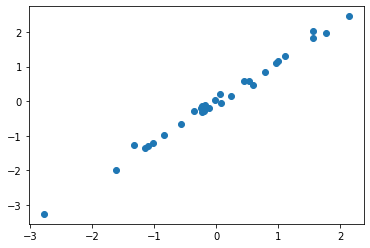

In [4]:
plt.scatter(x, y)

In [12]:
theta_init = torch.zeros(2)
gamma = 2.0
epsilon = 1e-3

In [13]:
N = x.shape[0]

In [14]:
theta = torch.zeros(5000, 2)
theta[0] = 2. * torch.randn(2)

for i in range(1, 5000):
    z = 1. * torch.randn(30, 1)
    
    update1 = -y.t() @ x + x.t() @ x * theta[i-1,0] + x.t() @ z * theta[i-1,1] + theta[i-1,0]/gamma**2
    update2 = -z.t() @ y + z.t() @ x * theta[i-1,0] + z.t() @ z * theta[i-1,1] + theta[i-1,1]/gamma**2
    update = torch.stack((update1,update2)).squeeze()
    theta[i] = theta[i-1] - (epsilon / 2) * update + epsilon**0.5 * torch.randn(2)

In [46]:
thetac2 = torch.zeros(5000, 2)
thetac2[0] = 2. * torch.randn(2)

for i in range(1, 5000):
    z = 0. * torch.randn(30, 1)
    
    update1 = -y.t() @ x + x.t() @ x * thetac2[i-1,0] + x.t() @ z * thetac2[i-1,1] + thetac2[i-1,0]/gamma**2
    update2 = -z.t() @ y + z.t() @ x * thetac2[i-1,0] + z.t() @ z * thetac2[i-1,1] + thetac2[i-1,1]/gamma**2
    update = torch.stack((update1,update2)).squeeze()
    thetac2[i] = thetac2[i-1] - (epsilon / 2) * update + (0.01 * epsilon)**0.5 * torch.randn(2)

In [36]:
thetac = torch.zeros(5000, 2)
thetac[0] = 2. * torch.randn(2)

for i in range(1, 5000):
    z = 1. * torch.randn(30, 1)
    
    update1 = -y.t() @ x + x.t() @ x * thetac[i-1,0] + x.t() @ z * thetac[i-1,1] + thetac[i-1,0]/gamma**2
    update2 = -z.t() @ y + z.t() @ x * thetac[i-1,0] + z.t() @ z * thetac[i-1,1] + thetac[i-1,1]/gamma**2
    update = torch.stack((update1,update2)).squeeze() / 0.01
    thetac[i] = thetac[i-1] - (epsilon / 2) * update + epsilon**0.5 * torch.randn(2)

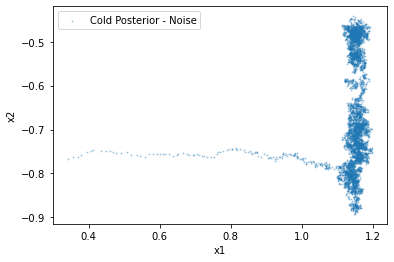

In [47]:
# plt.scatter(*theta.t(), s=1, label = "True Posterior")
# plt.scatter(*thetac.t(), s=1, alpha = 0.3, label = "Cold Posterior - Potential")
plt.scatter(*thetac2.t(), s=1, alpha = 0.3, label = "Cold Posterior - Noise")
plt.xlabel("x1")
plt.ylabel("x2")

# plt.xlim((0, 2))
# plt.ylim((-1, 1))
plt.legend()

In [42]:
torch.cov(theta[-2500:].t()) # zero variance on z

tensor([[ 0.0305, -0.0012],
        [-0.0012,  0.0300]])

In [43]:
torch.cov(thetac2[-3500:].t()) # variance 1 on z

tensor([[0.0003, 0.0004],
        [0.0004, 0.0821]])

In [26]:
(x.t()@x + 1/gamma*2).pow(-1.0)

tensor([[0.0284]])

In [68]:
gamma = 0.1

def post_var_function_of_z(z_scale = 1.0):
    theta = torch.zeros(5000, 2)
    theta[0] = gamma * torch.randn(2)

    for i in range(1, 5000):
        z = z_scale * torch.randn(30, 1)

        update1 = -y.t() @ x + x.t() @ x * theta[i-1,0] + x.t() @ z * theta[i-1,1] + theta[i-1,0]/gamma**2
        update2 = -z.t() @ y + z.t() @ x * theta[i-1,0] + z.t() @ z * theta[i-1,1] + theta[i-1,1]/gamma**2
        update = torch.stack((update1,update2)).squeeze()
        theta[i] = theta[i-1] - (epsilon / 2) * update + epsilon**0.5 * torch.randn(2)
    return torch.cov(theta[-2500:].t())

In [62]:
z_scales = [1e-4, 0.001, 0.01, 0.1, 1.0, 2.0]

var_theta0 = [[post_var_function_of_z(z)[0,0] for z in z_scales] for _ in range(3)]

In [67]:
[post_var_function_of_z(0)[0,0] for _ in range(5)]

[tensor(0.0018),
 tensor(0.0018),
 tensor(0.0017),
 tensor(0.0018),
 tensor(0.0018)]

In [63]:
(x.t()@x + 1/gamma*2).pow(-1.0)

tensor([[0.0424]])

In [25]:
def get_random_var(z_scale=1.0):
    z = z_scale * torch.randn(30, 1)
    features = torch.cat((x, z),dim=-1)
    covmat = features.t() @ features + torch.eye(2) / gamma**2
    return covmat.inverse()[0,0]


In [26]:
all_rand_vars = torch.tensor([[get_random_var(z) for z in z_scales] for _ in range(1000)])

In [27]:
def get_scalarization_post(z_scale=1.0, repeats = 5):
    feat_list = []
    for _ in range(repeats):
        z = z_scale * torch.randn(30, 1)
        feat_list.append(torch.cat((x, z),dim=-1))
    features = torch.cat(feat_list, dim=0)
    # print(features.shape)
    covmat = features.t() @ features + torch.eye(2) / gamma**2
    return covmat.inverse()[0,0]

In [28]:
all_5x_repeats = torch.tensor([[get_scalarization_post(z, repeats=5) for z in z_scales] for _ in range(1000)])

In [29]:
all_5x_repeats.mean(0)

tensor([0.0088, 0.0088, 0.0089, 0.0089])

In [30]:
all_20x_repeats = torch.tensor([[get_scalarization_post(z, repeats=20) for z in z_scales] for _ in range(1000)])

Text(0.5, 0, 'Stddev of z')

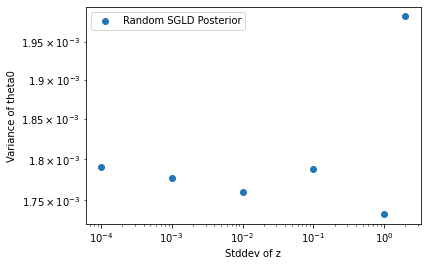

In [65]:
plt.scatter(z_scales, torch.tensor(var_theta0).mean(0), label = "Random SGLD Posterior")
# plt.scatter(z_scales, all_rand_vars.mean(0), label = "Exp. Nuisance Posterior", color = "green")
# plt.scatter(z_scales, all_5x_repeats.mean(0), label = "Exp. 5x Repeat Posterior", color = "orange")
# plt.scatter(z_scales, all_20x_repeats.mean(0), label = "Exp. 20x Repeat Posterior", color = "brown")
# plt.axhline((x.t()@x + 1/gamma*2).pow(-1.0), color = "red", label = "Original Bayesian Posterior")
plt.semilogx()
plt.semilogy()
plt.ylabel("Variance of theta0")
plt.legend()

plt.xlabel("Stddev of z")

In [20]:
ranges = torch.linspace(1, 5000, 500).long()
repeat_ranges = torch.tensor([get_scalarization_post(repeats=x) for x in ranges])

Text(0, 0.5, 'Posterior Variance')

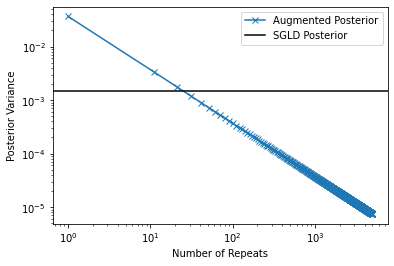

In [21]:
plt.plot(ranges, repeat_ranges, marker = "x", label = "Augmented Posterior")
plt.axhline(torch.tensor(var_theta0)[..., 0].mean(), color = "black", label = "SGLD Posterior")
plt.semilogx()
plt.semilogy()
plt.legend()
plt.xlabel("Number of Repeats")
plt.ylabel("Posterior Variance")

In [22]:
ranges[2]

tensor(21)